<a href="https://colab.research.google.com/github/kelvin-kiplagat/KE-Urbanization/blob/main/DTE_Team_91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pygsheets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 5.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pygsheets
import statsmodels.formula.api as smf
from functools import reduce

%matplotlib inline
plt.style.use("seaborn-v0_8")

## **Mount Google Drive and Authorize API**

In [ ]:
from google.colab import drive
drive.mount('drive')

# Authenticate pygsheets
gc = pygsheets.authorize(service_account_file="./drive/MyDrive/Colab Notebooks/iam_google_auth_kelvin39.json")

Mounted at drive


In [ ]:
# Function to load data from google sheets

def create_frame(api_key, tab_title):
    """
    This function creates a dataframe from google spreadsheets. It accepts the
    sheet API key and the specific tab title
    """
    sheet = gc.open_by_key(api_key)
    data_records = sheet.worksheet_by_title(tab_title).get_all_values()
    data = pd.DataFrame.from_records(data_records)
    data = data.loc[(data.iloc[:, 0] != '') |
                    (data.iloc[:, 1] != ''), :].reset_index(drop = True)
    return data

def rename_columns(df, col_row = 1):
    """This function renames columns depending on where the column names are located"""
    if col_row == 1:
        df.columns = df.iloc[0, :].apply(lambda x: x.strip(" "))
        df = df.drop(0).reset_index(drop = True)
    else:
        df.columns = df.iloc[col_row-1, :].apply(lambda x: x.strip(" "))
        df = df.drop([i for i in range(col_row)]).reset_index(drop = True)
    df[df.columns[0]] = df.iloc[:, 0].apply(lambda x: x.strip(" ")) #clear spaces
    return df

def clean_numerics(df, col_start):
    """This function cleans the numeric data"""
    columns_to_clean = df.columns.tolist()[col_start:]
    # the line below cleans the numeric values by removing commas if any. Combines the series generated into 1 df
    df[columns_to_clean] = reduce(lambda x, y : pd.concat([x, y], axis = 1),
                                  [pd.to_numeric(df[col].apply(lambda x: x.replace(',', ''))) for col in columns_to_clean])
    return df

## **Reading Data into Console**

In [ ]:
# Urban and Rural County POP 2019 census
rural = create_frame("1wqYElabEqccEeHytLGd4KNy8sKe5g-W4SatLnHue-qE", "Rural pop by sex and county").iloc[:-1, :2]
urban = create_frame("1VGEgtCwT6FLDdTenPuwz8mhF-XtjhhzfvI7biNZHU40", "Urban Pop by Sex and County").iloc[:-1, :2]
rural, urban = rename_columns(rural, 2), rename_columns(urban, 2)
county_total_pop = pd.merge(rural.loc[1:, :], urban.loc[1:, :], left_on = 'County', right_on = 'County', suffixes = ["_rur", "_urb"])
county_total_pop = clean_numerics(county_total_pop, 1)
county_total_pop.head()

1,County,Total_rur,Total_urb
0,Mombasa,0,1208333
1,Kwale,740389,126431
2,Kilifi,1059899,393888
3,Tana River,240221,75722
4,Lamu,105474,38446


In [ ]:
# Production
production = create_frame("1kgcp80x1tD8XsIrTMVXmGljZm5_lCINbcGsGIxslJUQ", "Table 7.16")
# production = production.drop([8,9])
production = rename_columns(production, col_row = 2)
production = clean_numerics(production, col_start = 1)
production = production.drop([5, 6])
production['Year'] = production.Year.apply(lambda x: int(x[:4]))
production # Production is in '000 Tonnes

1,Year,Production,Imports,Exports
0,2018,491.1,284.2,2.0
1,2019,440.9,458.6,0.8
2,2020,603.8,442.4,0.4
3,2021,700.2,426.3,0.1
4,2022,796.6,320.7,0.4


In [ ]:
# Kenyan Population, Urban population, Rural Population, and GDP over time
pop_gdp = create_frame("15Bc53nhudgxFNJxrk7QvB6N_SaFP5mFo2Tdeyxazmpc", "gdp_pop")
pop_gdp = rename_columns(pop_gdp)
pop_gdp = clean_numerics(pop_gdp, col_start = 0)
pop_gdp.head(5)

,Year,GDP(USD),Population,Urban Population,Rural Population
0,2000,12705350153,30851606,6137001,24714605
1,2001,12986007426,31800343,6436071,25364272
2,2002,13147736954,32779823,6749693,26030130
3,2003,14904517650,33767122,7073537,26693585
4,2004,16095337094,34791836,7414140,27377696


In [ ]:
# Urban population across major Towns
urban_pop_cities = create_frame("15Bc53nhudgxFNJxrk7QvB6N_SaFP5mFo2Tdeyxazmpc", "urban_pop_cities")
urban_pop_cities = rename_columns(urban_pop_cities)
urban_pop_cities = clean_numerics(urban_pop_cities, col_start = 1)
urban_pop_cities['Year'] = urban_pop_cities.Year.apply(lambda x: int(x[:4]))
urban_pop_cities.head(5)

,Year,Nairobi,Mombasa,Nakuru,Kisumu,Eldoret,Ruiru
0,2000,2214000,683000,224000,199000,173000,88000
1,2001,2299000,706000,230000,205000,180000,98000
2,2002,2388000,728000,237000,211000,188000,109000
3,2003,2481000,752000,243000,217000,196000,121000
4,2004,2577000,776000,250000,224000,204000,135000


In [ ]:
# County population
county_pop = create_frame('1cWaTzFGxng77cu-UCFpkeXjyOCQMq46-JBDlO8BFsLo', 'Pop by Sex and County')
county_pop = rename_columns(county_pop, col_row = 2)
county_pop = county_pop.iloc[1:, :4] # Select the three necessary columns
county_pop = clean_numerics(county_pop, col_start = 1)
county_pop.head(5)

1,County,Total,Male,Female
1,MOMBASA,1208333,610257,598046
2,KWALE,866820,425121,441681
3,KILIFI,1453787,704089,749673
4,TANA RIVER,315943,158550,157391
5,LAMU,143920,76103,67813


In [ ]:
# Primary and Secondary education access and Urban population by County
primary = create_frame('1hCYp41Z0gT5D0XPkGryP7_h2yx1uLZPVNdPK-a31OQU', 'Sheet1').iloc[:, :4]
secondary = create_frame('1-2-SKjf8xbIgvF7q3aYWPJodwkR5kbdU2SLZjAD0d78', 'Sheet1').iloc[:, :4]
urb_county_pop = create_frame('1VGEgtCwT6FLDdTenPuwz8mhF-XtjhhzfvI7biNZHU40', 'Urban Pop by Sex and County').iloc[:, :4]
primary, secondary, urb_county_pop = rename_columns(primary, 2), rename_columns(secondary, 2), rename_columns(urb_county_pop, 2)
educ_access = pd.merge(pd.merge(primary, secondary, left_on = 'County', right_on = 'County', suffixes = ["_pri", "_sec"]),
                       urb_county_pop, left_on = 'County', right_on = 'County')
educ_access.drop(0, inplace = True)
educ_access = clean_numerics(educ_access, 1)
educ_access.head(5)

1,County,Total_pri,Male_pri,Female_pri,Total_sec,Male_sec,Female_sec,Total,Male,Female
1,Mombasa,200140,99370,100770,70018,35322,34696,1208333,610257,598046
2,Kwale,208512,106403,102109,37439,19741,17698,126431,62395,64031
3,Kilifi,375381,190072,185309,84679,44545,40134,393888,191324,202558
4,Tana River,55350,28122,27228,12560,7369,5191,75722,37854,37867
5,Lamu,30722,15673,15049,7716,4157,3559,38446,19533,18911


## **Visualizing Urban Trends**

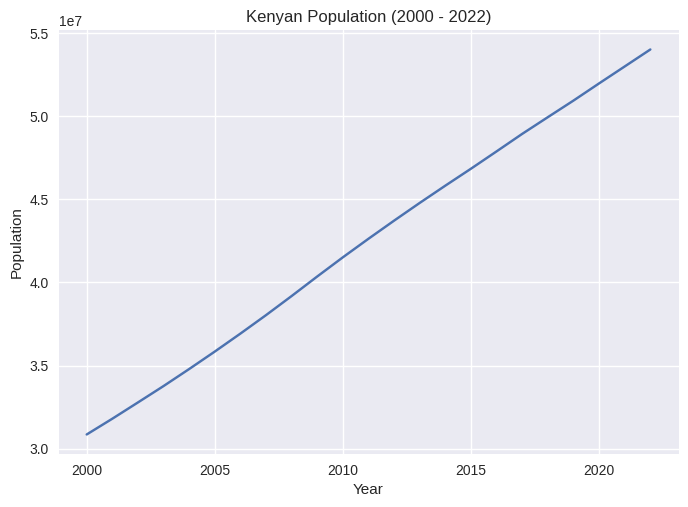

In [ ]:
plt.plot(pop_gdp['Year'], pop_gdp['Population'], 'x-')
plt.title("Kenyan Population (2000 - 2022)")
plt.xlabel('Year'), plt.ylabel('Population')
plt.show()

**Urban & Rural Population over time**

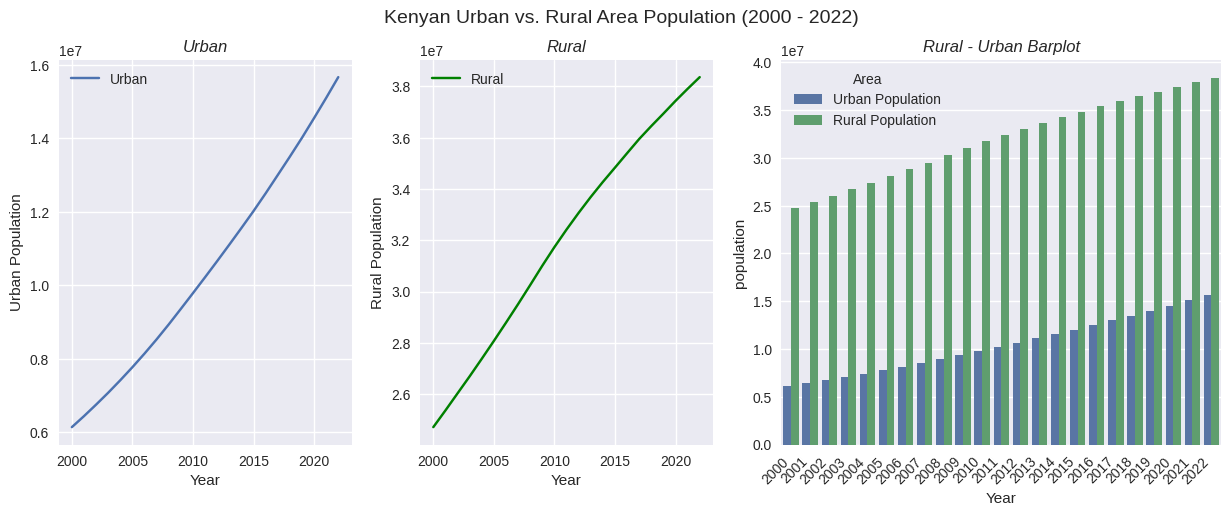

In [ ]:
fig, ax= plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5), gridspec_kw = {'width_ratios':[2, 2, 3]})
sns.lineplot(x = 'Year', y = 'Urban Population', data = pop_gdp, label = "Urban", markers = 'o', ax = ax[0])
sns.lineplot(x = 'Year', y = 'Rural Population', data = pop_gdp, label = "Rural", ax = ax[1], color = 'green')
ax[0].legend(loc = 'upper left'), ax[1].legend(loc = 'upper left')
ax[0].set_title("Urban", fontstyle = 'italic'), ax[1].set_title("Rural", fontstyle = 'italic')

# bar plot
rural_urban_melt = pd.melt(pop_gdp, id_vars = ['Year'], value_vars=['Urban Population', 'Rural Population'],
        var_name = 'Area', value_name = 'population').sort_values('Year')
sns.barplot(x = 'Year', y = 'population', data = rural_urban_melt, hue = 'Area', ax = ax[2])
ax[2].set_title("Rural - Urban Barplot", fontstyle = 'italic')
ax[2].set_xticks(ax[2].get_xticks())
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, ha='right')
fig.suptitle("Kenyan Urban vs. Rural Area Population (2000 - 2022)", fontsize = 14, fontweight = 15)
plt.show()

**2019 Heatmap Census**

In [ ]:
# Kenyan Population per County as of 2019 Census
with open('./drive/MyDrive/Datathon/Data/kenya.geojson') as file: # load the geojson file
    counties =  json.load(file)

county_total_pop['County'] = county_total_pop.County.apply(lambda x: x.upper())
county_total_pop['County'] = county_total_pop['County'].apply(lambda x: 'HOMA BAY' if x == 'HOMABAY' else x)
# Ensure the county names match as those in the json file
county_match = []
for county in county_total_pop.County:
    for dict_  in counties['features'][:-1]:
        geo_county = dict_['properties']['COUNTY_NAM']
        if county  == geo_county:
            county_match.append(county)
        elif county.split(" ")[0] in geo_county:
            county_match.append(geo_county)
        elif "-" in county:
            if (county.split("-")[0] in geo_county) or (county.split("-")[1] in geo_county):
                county_match.append(geo_county)

county_total_pop['geo_county'] = county_match

fig = make_subplots(
    rows=1, cols=2, subplot_titles=['Urban Population', 'Rural Population'],
    specs=[[{"type": "mapbox"}, {"type": "mapbox"}]]
)

# Draw the heat map
fig.append_trace(go.Choroplethmapbox(
    geojson = counties,
    locations = county_total_pop['geo_county'],
    z = county_total_pop['Total_urb'],
    colorscale = "Plotly3",
    colorbar=dict(thickness=20, x=0.46),
    featureidkey='properties.COUNTY_NAM',
    marker=dict(opacity=0.75)
    ), row=1, col=1)

fig.add_trace(go.Choroplethmapbox(
    geojson = counties,
    locations = county_total_pop['geo_county'],
    z = county_total_pop['Total_rur'],
    colorscale = "viridis",
    colorbar=dict(thickness=20, x=1.03),
    featureidkey='properties.COUNTY_NAM',
    marker=dict(opacity=0.75, line_width=0.5)), row=1, col=2)

fig.update_mapboxes(
        bearing=0,
        center = {"lat": -0.054932 , "lon": 37.46115},
 )

fig.update_layout(margin=dict(l=0, r=0, t=50, b=10))

fig.update_layout(
    mapbox1=dict(zoom=5, style='carto-positron'),
    mapbox2=dict(zoom=5, style='carto-positron')
    )
fig.show()

## **Impact on Socio-economic Indicators**
- **GDP and Population**

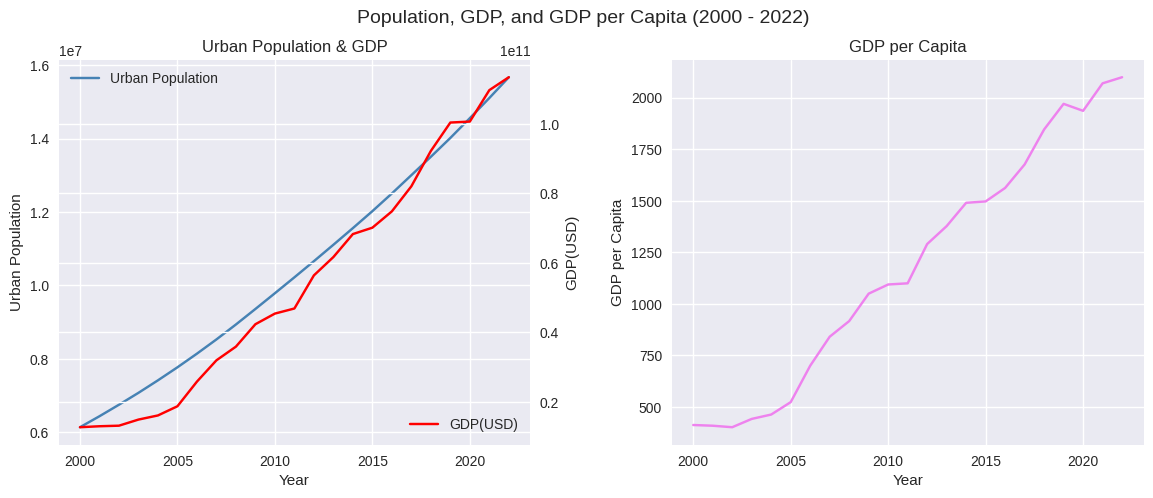

In [ ]:
fig, ax = plt.subplots(ncols = 2,figsize = (14, 5), gridspec_kw = {'wspace': 0.3})
ax_ = ax[0].twinx() # secondary axis
pop_gdp.plot(x = 'Year', y = 'Urban Population', kind = 'line', color = 'steelblue', ax = ax[0])
pop_gdp.plot(x = 'Year', y = 'GDP(USD)', kind = 'line', color = 'red', ax = ax_)
ax[0].set_ylabel('Urban Population'), ax_.set_ylabel('GDP(USD)'), ax[0].set_xlabel('Year')
ax[0].set_title('Urban Population & GDP')
ax_.legend(loc = 'lower right')

# GDP per Capita
sns.lineplot(x = pop_gdp['Year'], y = pop_gdp['GDP(USD)'] / pop_gdp['Population'], ax = ax[1], color = 'violet')
ax[1].set_ylabel("GDP per Capita")
ax[1].set_title('GDP per Capita')
fig.suptitle('Population, GDP, and GDP per Capita (2000 - 2022)', fontweight = 20, fontsize = 14)
plt.show()

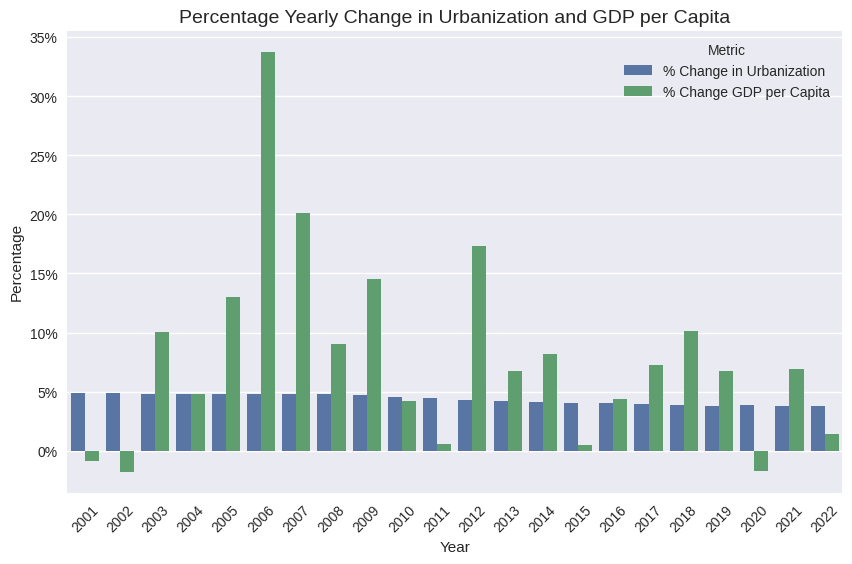

In [ ]:
# % Change in Urbanization  = [(Urban Population in Later Year - Urban Population in Earlier Year) / Urban Population in Earlier Year]
urbanization_pc_change = pop_gdp['Urban Population'].diff(1).to_numpy()[1:] / pop_gdp['Urban Population'].to_numpy()[:-1]
gdp_pc = pop_gdp['GDP(USD)'] / pop_gdp['Population']
gdp_pc_rate = gdp_pc.diff(1).to_numpy()[1:] / gdp_pc.to_numpy()[:-1]

metric_df = pd.melt(
    pd.DataFrame({"Year": range(2001, 2023),
              "% Change in Urbanization": urbanization_pc_change,
              "% Change GDP per Capita": gdp_pc_rate}),
    id_vars = ['Year'],
    value_vars=['% Change in Urbanization', '% Change GDP per Capita'],
    var_name = 'Metric', value_name = 'Percentage'
    )
fig, ax = plt.subplots(figsize =( 10, 6))
sns.barplot(data = metric_df, x = 'Year', y = 'Percentage', hue = 'Metric', ax = ax)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title("Percentage Yearly Change in Urbanization and GDP per Capita", fontweight = 20, fontsize = 14)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0%}"))
plt.show()

- **Urban Population, Production, Exports, Imports**

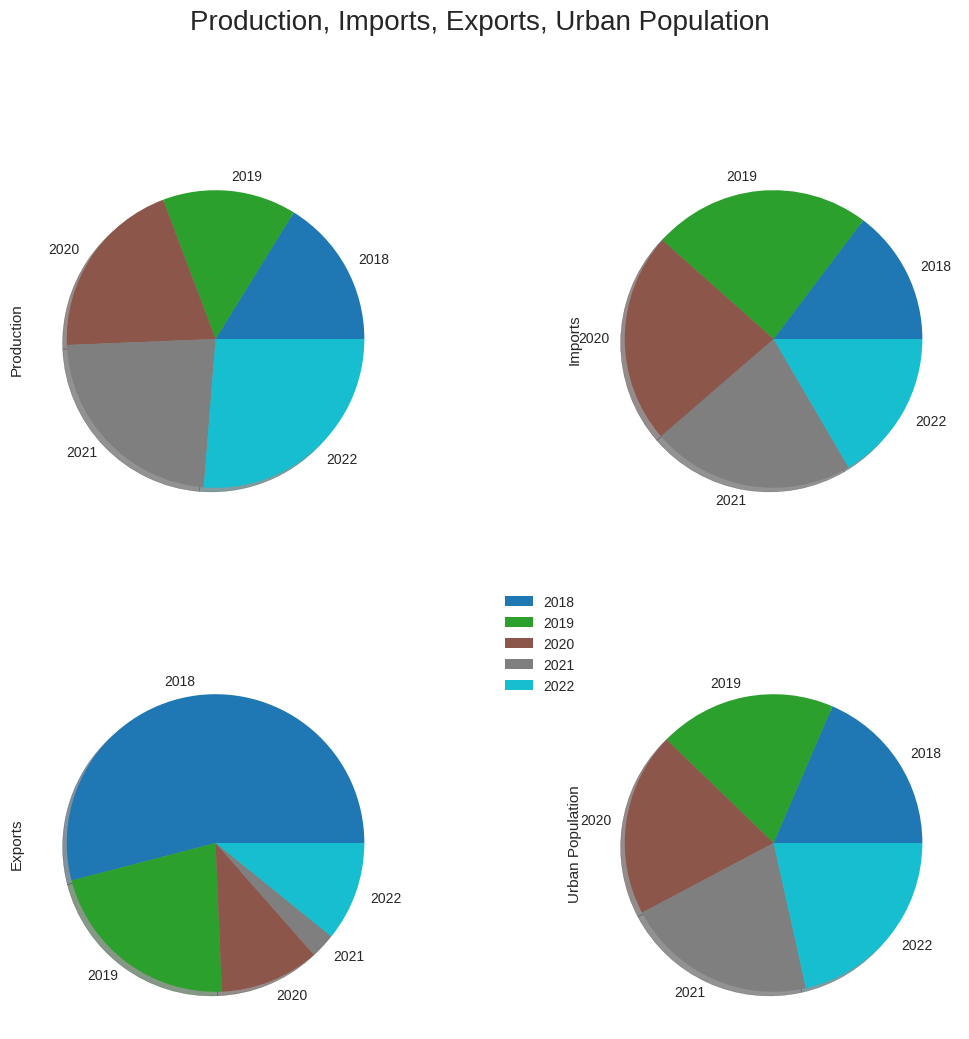

In [ ]:
prod_urb = pd.merge(production, pop_gdp[['Year', 'Urban Population']], right_on = 'Year', left_on = 'Year', how = 'inner').set_index('Year')
fig, ax = plt.subplots(2,2, figsize = (12, 12))
prod_urb.plot(kind = 'pie', subplots = True, legend = False, shadow=True, colormap = 'tab10', ax = ax)
plt.subplots_adjust(wspace=0.5)
plt.legend(bbox_to_anchor = (0, 1.2))
fig.suptitle("Production, Imports, Exports, Urban Population", fontsize = 20, fontweight = 14)
plt.show()

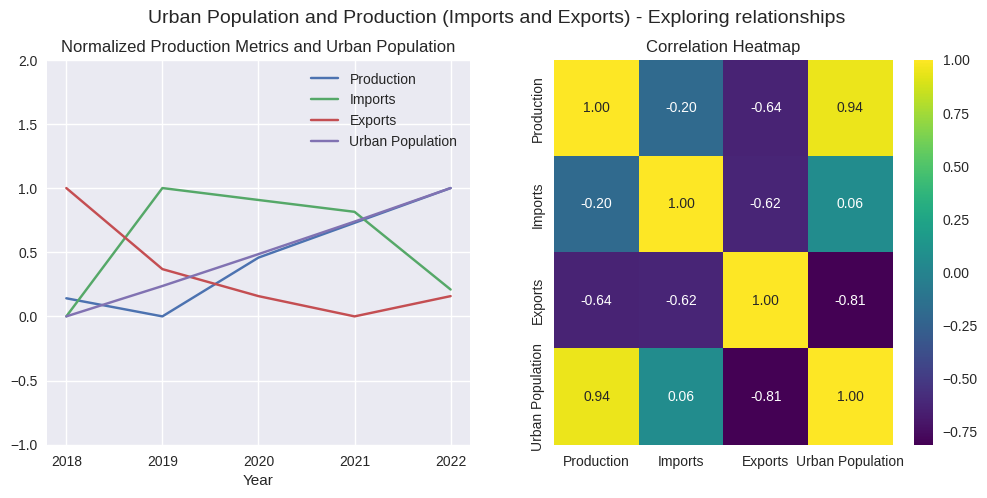

In [ ]:
# Visualizing Normalized data to use them in a single scale
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))
prod_urb_norm = (prod_urb - prod_urb.min()) / (prod_urb.max() - prod_urb.min())
prod_urb_norm.plot(kind = 'line', ax = ax[0])
ax[0].set_ylim(-1,2)
ax[0].set_xticks(range(2018, 2023))
ax[0].set_xticklabels(ax[0].get_xticklabels())
ax[0].set_title("Normalized Production Metrics and Urban Population")


# Correlation Heatmap between the 4 variables
sns.heatmap(prod_urb.corr(), ax = ax[1], fmt = ".2f", annot = True, cmap = 'viridis')
ax[1].set_title("Correlation Heatmap")
fig.suptitle("Urban Population and Production (Imports and Exports) - Exploring relationships", fontsize = 14, fontweight = 14)
plt.show()

In [ ]:
# Quantify how does the production metrics affect urbanization
df_prod = prod_urb.rename(columns = {'Urban Population':'urbanPopulation'})
model = smf.ols(formula = 'urbanPopulation ~ Production + Imports + Exports', data = df_prod).fit()
# model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        urbanPopulation   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     673.9
Date:                Tue, 03 Oct 2023   Prob (F-statistic):             0.0283
Time:                        17:22:33   Log-Likelihood:                -55.814
No. Observations:                   5   AIC:                             119.6
Df Residuals:                       1   BIC:                             118.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.711e+07   1.86e+06     14.588      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 5 samples were given.



- **Education Access by County as a Percentage of the Urban Population**

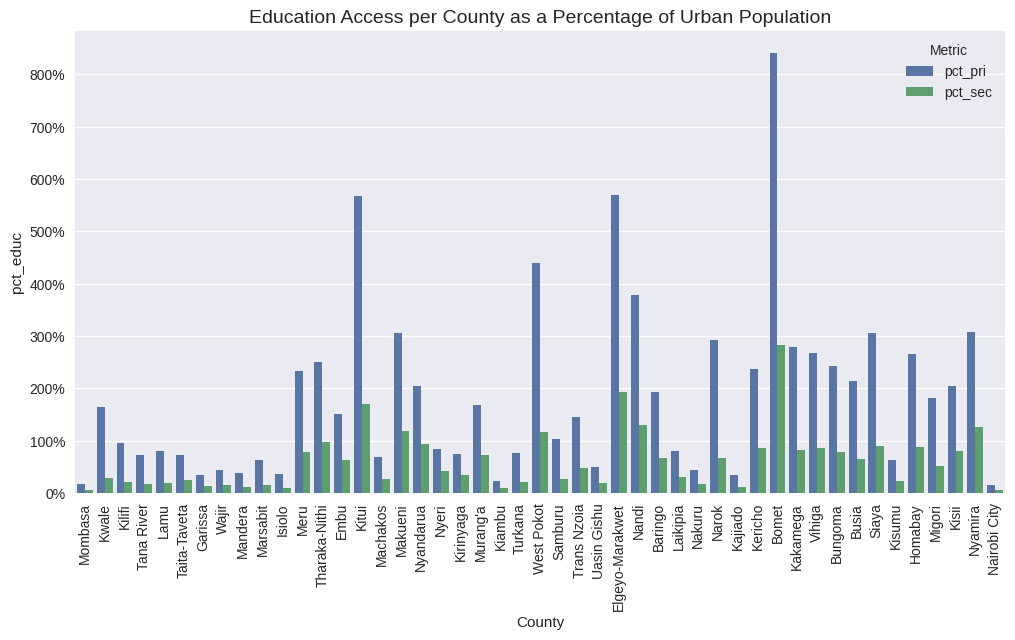

In [ ]:
# Percentage of students in school relative to the urban population
educ_access['pct_pri'] = educ_access['Total_pri'] / educ_access['Total']
educ_access['pct_sec'] = educ_access['Total_sec'] / educ_access['Total']
df_ed = pd.melt(educ_access, id_vars = ['County'], value_vars = ['pct_pri', 'pct_sec'], value_name = 'pct_educ', var_name = 'Metric')

# Visualiza
fig, ax = plt.subplots(figsize =( 12, 6))
sns.barplot(df_ed, x = 'County', y = 'pct_educ', hue = 'Metric', ax = ax)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Education Access per County as a Percentage of Urban Population", fontweight = 20, fontsize = 14)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0%}"))
plt.show()

## **Regional Differences**
- **Urbanization Change over Time**

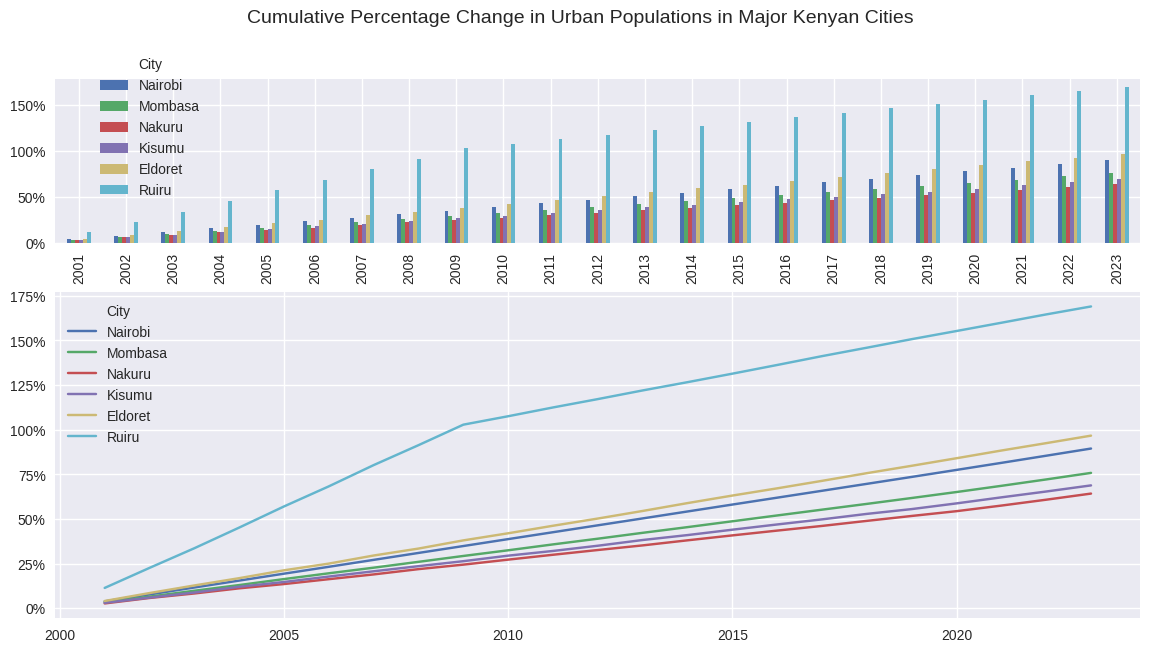

In [ ]:
urb_city_pop = urban_pop_cities.set_index('Year')
# Cumulaive Yearly percentage changes in urban population
pct_chng = pd.DataFrame(urb_city_pop.diff(1).iloc[1:, :].to_numpy() / urb_city_pop.iloc[:-1, :].to_numpy(),
             columns = urb_city_pop.columns,
             index = range(2001, 2024))
pct_chng_csum = pct_chng.cumsum()

fig, ax = plt.subplots(2, figsize = (14,14), gridspec_kw = {'height_ratios': [1, 2]})
pct_chng_csum.plot(kind = 'bar', figsize = (14, 7), ax = ax[0])
pct_chng_csum.plot(kind = 'line', figsize = (14, 7), ax = ax[1])
ax[0].legend(title = 'City', bbox_to_anchor = [0.03, 0.2]), ax[1].legend(title = 'City')
ax[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0%}"))
ax[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0%}"))
fig.suptitle("Cumulative Percentage Change in Urban Populations in Major Kenyan Cities", fontweight = 20, fontsize = 14)
plt.show()


- **What Average Percentage can we Expect Major Cities to Urbanize Over Time?**

In [ ]:
avg_pct_chng_csum = pct_chng_csum.mean(axis = 1).to_frame().rename(columns = {0:'avg_cum_pct_chng'})
avg_pct_chng_csum['t'] = range(1, avg_pct_chng_csum.shape[0]+1)

# Regression Model
model_= smf.ols(formula = 'avg_cum_pct_chng ~ t', data = avg_pct_chng_csum).fit()
# model summary
print(model_.summary())

                            OLS Regression Results                            
Dep. Variable:       avg_cum_pct_chng   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     5716.
Date:                Tue, 03 Oct 2023   Prob (F-statistic):           4.50e-27
Time:                        17:23:26   Log-Likelihood:                 62.470
No. Observations:                  23   AIC:                            -120.9
Df Residuals:                      21   BIC:                            -118.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0402      0.007      5.575      0.0

In [ ]:
avg_pct_chng_csum

,avg_cum_pct_chng,t
2001,0.047184,1
2002,0.094895,2
2003,0.141280,3
2004,0.189312,4
2005,0.236934,5
2006,0.283403,6
2007,0.331853,7
2008,0.378611,8
2009,0.426158,9
2010,0.462290,10


## **Data Spreadsheet Tables**

**Agriculture Sector**<br>
API Key = 1kgcp80x1tD8XsIrTMVXmGljZm5_lCINbcGsGIxslJUQ<br>
*Important Tables*
- Table 7.9 : Produced Bags in Millions
- Table 7.10 : Retail Prices per KG
- Table 7.16 : Imports & exports sugar

**Education Enrolment - Primary School by Sex & County**<br>
API Key = 1hCYp41Z0gT5D0XPkGryP7_h2yx1uLZPVNdPK-a31OQU<br>
*Important Tables(s)*
- Sheet 1

**Education Enrolment - Secondary School by Sex & County**<br>
API Key = 1-2-SKjf8xbIgvF7q3aYWPJodwkR5kbdU2SLZjAD0d78<br>
*Important Tables(s)*
- Sheet 1

**Disability Prevalence by County and Residence**<br>
API Key = 1ArCUzjddL1xrBOX-bvX_59IwucRPHL9gJoH6W0yczHc<br>
*Important Tables(s)*
- Sheet 1

**Population Households Density by County**<br>
API Key = 1cWaTzFGxng77cu-UCFpkeXjyOCQMq46-JBDlO8BFsLo<br>
*Important Tables*
- Pop by Sex and County

**Population-in-urban-centers-by-sex-and-urban-center**<br>
API Key = 1TbrrDSFdw6yXuBc71ulEZ7A1Zex_pMSNwheusULnftY<br>
*Important Tables*
- Pop by Urban Center and Sex

**Public Finance - County Government Revenues**<br>
API Key = 1rsoVofj_OCJQZThmljJHtVCMPAri8DnspMs2DXHzyzY<br>
*Important Tables*
- Table 5.13

**Rural-population-households-density-by-county**<br>
API Key = 1wqYElabEqccEeHytLGd4KNy8sKe5g-W4SatLnHue-qE<br>
*Important Tables*
- Rural pop by sex and county

**Urban-population-households-density-by-county**<br>
API Key = 1VGEgtCwT6FLDdTenPuwz8mhF-XtjhhzfvI7biNZHU40<br>
*Important Tables*
- Urban Pop by Sex and County

**Aggregated Urban-Kenyan Pop-GDP over time**<br>
API Key = 1VGEgtCwT6FLDdTenPuwz8mhF-XtjhhzfvI7biNZHU40<br>
*Important Tables*
- urban_pop_cities
- gdp_pop